In [4]:
import numpy as np

In [5]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

mean = train_data.mean(axis = 0)
train_data -= mean # shift
std = train_data.std(axis = 0)
train_data /= std # rescale

test_data -= mean
test_data /= std

from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, 
                           activation = 'relu', 
                           input_shape = (train_data.shape[1], )))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    
    return model

In [6]:
import tensorflow as tf

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        c = ['\b|', '\b/', '\b-', '\b\\'] 
        print(c[epoch % 4], end='')
    def on_epoch_end(self, epoch, logs=None):
        print('\b', end='')

In [7]:
import numpy as np, tensorflow as tf
K = 4
num_val_samples = len(train_data) // K
num_epochs = 500
all_mae_histories = []
for i in range(K):
    print('processing fold', i)
    
    # Prepare the validation data: data from partition i
    a, b = i * num_val_samples, (i + 1) * num_val_samples
    val_data = train_data[a : b]
    val_targets = train_targets[a : b]
    
    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[:a], train_data[b:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:a], train_targets[b:]], axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0, callbacks=[CustomCallback()])

    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold 0
processing fold 1
processing fold 2
processing fold 3


We will now extend the run to 500 epochs and use a `history` object to record validation MAE at each epoch

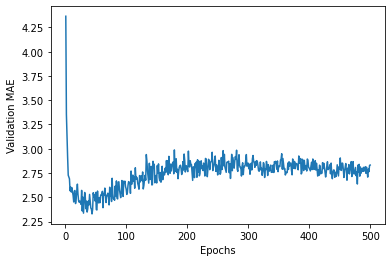

In [12]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories])for i in range(num_epochs)]

import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

The plot is noisy and the first few points are at a different scale

Smooth data and omit first 10 points

In [13]:
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points: # an empty list is 'False'
            previous = smoothed_points[-1] # the last appended point
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

Code to smooth data by replacing each data point with a weighted sum of itself and the previous smoothed point.

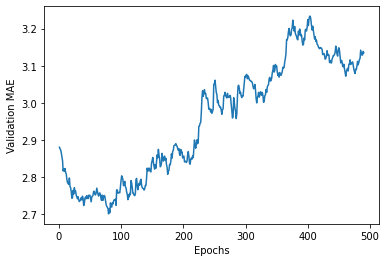

In [14]:
smooth_mae_history = smooth_curve(mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

The smoothed outcome, omitting the first 10 points

In [15]:
print(np.argmin(smooth_mae_history))

79


Lowest MAE occurs at epoch...